# Clustering of CLS dataset with FlauBERT embedding 

## Introduction

### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### What is FlauBERT?
FlauBERT – French Language Understanding via Bidirectional Encoder Representations from Transformers, a French BERT model that outperforms multilingual/cross-lingual models in several downstream NLP tasks, under similar configurations. FlauBERT relies on freely available datasets and is made publicly available in different versions.

### What is CLS dataset?

The Cross-Lingual Sentiment (CLS) dataset comprises about 800.000 Amazon product reviews in the four languages English, German, French, and Japanese.

For more information on the construction of the dataset see (Prettenhofer and Stein, 2010) or the enclosed readme files. If you have a question after reading the paper and the readme files, please contact Peter Prettenhofer.

We provide the dataset in two formats: 1) a processed format which corresponds to the preprocessing (tokenization, etc.) in (Prettenhofer and Stein, 2010); 2) an unprocessed format which contains the full text of the reviews (e.g., for machine translation or feature engineering).

The dataset was first used by (Prettenhofer and Stein, 2010). It consists of Amazon product reviews for three product categories---books, dvds and music---written in four different languages: English, German, French, and Japanese. The German, French, and Japanese reviews were crawled from Amazon in November, 2009. The English reviews were sampled from the Multi-Domain Sentiment Dataset (Blitzer et. al., 2007). For each language-category pair there exist three sets of training documents, test documents, and unlabeled documents. The training and test sets comprise 2.000 documents each, whereas the number of unlabeled documents varies from 9.000 - 170.000.


Let's get started!

## Install and Import

In [0]:
# to get more RAM
a = []
while(1):
    a.append('1')

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for FlauBERT by Hugging Face Transformer. 

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [2]:
!pip install transformers
!pip install tqdm
!pip install nltk

In [219]:
###system###
import io
from tqdm import tqdm, trange
from tqdm import tqdm_notebook as tqdm
from lxml import etree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

###ML###
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

###NLP###
import nltk
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from transformers import FlaubertTokenizer, FlaubertModel, BertTokenizer

###Visualization###
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
%matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

*texte en italique*
## Load CLS Dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def extract_info(file_dvd, file_books, file_music):
    tree_dvd = etree.parse(file_dvd)
    tree_music = etree.parse(file_music)
    tree_books = etree.parse(file_books)
    trees = [tree_dvd, tree_music, tree_books]
    categories = []
    ratings = []
    texts = []
    titles = []
    sentiments = []
    for tree in trees:
        for category in tree.xpath("/items/item/category"):
            categories.append(category.text)
        for rating in tree.xpath("/items/item/rating"):
            ratings.append(rating.text)
        for text in tree.xpath("/items/item/text"):
            texts.append(text.text)
        for title in tree.xpath("/items/item/title"):
            titles.append(title.text)

        # for sentiment in tree.xpath("/items/item/title"):
           # sentiment.append(title.text)

    df = pd.DataFrame(data=np.array([categories, titles, texts, ratings]).T, columns=[
                      "category", "title", "review", "rating"])
    return df

In [0]:
df = extract_info("/content/drive/My Drive/Colab Notebooks/fr/dvd/test.review",
                  "/content/drive/My Drive/Colab Notebooks/fr/books/test.review",
                  "/content/drive/My Drive/Colab Notebooks/fr/music/test.review")

In [0]:
data=df
df.head()

category  ... rating
0      DVD  ...    2.0
1      DVD  ...    2.0
2      DVD  ...    2.0
3      DVD  ...    2.0
4      DVD  ...    2.0

[5 rows x 4 columns]

In [0]:
def identify_tokens(row):
    review = str(row.review)
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

data['review'] = df.apply(identify_tokens, axis=1)
data.head()

category  ... rating
0      DVD  ...    2.0
1      DVD  ...    2.0
2      DVD  ...    2.0
3      DVD  ...    2.0
4      DVD  ...    2.0

[5 rows x 4 columns]

In [0]:
# French stopwords ressource https://github.com/stopwords-iso/stopwords-fr

stopwords=[",",".",";","qu'un","d'un","qu'il","c'est","d'une","j'ai","n'est",
           "a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient","allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez","attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai","auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant","autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah","bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche","chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic","combien","comme","comment","comparable","comparables","compris","concernant","contre","couic","crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere","derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent","différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers","diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont","dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet","egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]

stops = set(stopwords)    

In [0]:
def remove_stops(row):
    my_list = row['review']
    meaningful_words = [w for w in my_list if not w.lower() in stops]
    return (meaningful_words)

data['review'] = data.apply(remove_stops, axis=1)
data['review']=data['review']
data.head()

category  ... rating
0      DVD  ...    2.0
1      DVD  ...    2.0
2      DVD  ...    2.0
3      DVD  ...    2.0
4      DVD  ...    2.0

[5 rows x 4 columns]

In [0]:
def try_join(l):
    try:
        return ' '.join(map(str, l))
    except TypeError:
        return np.nan

data['review'] = [try_join(l) for l in data['review']]
data.head()

category  ... rating
0      DVD  ...    2.0
1      DVD  ...    2.0
2      DVD  ...    2.0
3      DVD  ...    2.0
4      DVD  ...    2.0

[5 rows x 4 columns]

In [0]:
data.sample(frac=1).head()

category  ... rating
129       DVD  ...    5.0
668       DVD  ...    5.0
297       DVD  ...    5.0
5140   Livres  ...    1.0
5222   Livres  ...    1.0

[5 rows x 4 columns]

In [0]:
#save cleaned reviews 
data.to_csv('/content/drive/My Drive/Colab Notebooks/review_cleaned0413.csv', index=False)

In [7]:
#read the cleaned reviews
#data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/review_cleaned0413.csv') 
data = pd.read_csv('/Users/yang/Documents/GitHub/Projet_Fil_Rouge-IBM/CLS project/review_cleaned0413.csv') 

In [8]:
data.head()     

category                                              title  \
0      DVD         X-men origins - Wolverine - Edition simple   
1      DVD         X-men origins - Wolverine - Edition simple   
2      DVD  Harry Potter et le prince de sang-mêlé - Editi...   
3      DVD                X-men origins - Wolverine [Blu-ray]   
4      DVD               Kaamelott : Livre VI - Coffret 4 DVD   

                                              review  rating  
0  premiers talentueux Brian Singer wolverine opp...     2.0  
1  attendait génèse effets numériques service fil...     2.0  
2  histoire livre scènes rajoutées avancer élémen...     2.0  
3  Wolverine porté excellent Hugh Jackman Logan V...     2.0  
4  Grand fan période épisodes courts drôles série...     2.0

In [0]:
# Create sentence and label lists
reviews = data.review.values
#reviews = str(df.review.values)

# not for FlauBERT 
#reviews = ["[CLS] " + str(review) + " [SEP]" for review in reviews]

In [0]:
str(reviews[10])

'James Bond Casino Royale numéro Daniel Craig Bond solide crédible acteurs tirent honneurs Amalric réalisation rapide hachée saccadée brusque nerveuse tendue perd compréhension scènes confus général jeu ressort vaguement frustré réalisateur Marc Forster doute voulu Bond traditionnel tournant trilogie Jason Bourne Bond Bond tolère évolutions Bond veut bref attend prochain impatience'

## Prepare FlauBERT 

Next, import the FlauBERT tokenizer, used to convert our text into tokens that correspond to FlauBERT's vocabulary.

In [0]:
tokenizer = FlaubertTokenizer.from_pretrained('flaubert-base-uncased')
tokenized_texts = [tokenizer.tokenize(str(review)) for review in reviews]
print ("Tokenize the first sentence:")
print (tokenized_texts[10])


Tokenize the first sentence:
['james</w>', 'bond</w>', 'casino</w>', 'royale</w>', 'numéro</w>', 'daniel</w>', 'craig</w>', 'bond</w>', 'solide</w>', 'crédible</w>', 'acteurs</w>', 'tirent</w>', 'honneurs</w>', 'amal', 'ric</w>', 'réalisation</w>', 'rapide</w>', 'hachée</w>', 'sac', 'ca', 'dée</w>', 'brusque</w>', 'nerveuse</w>', 'tendue</w>', 'perd</w>', 'compréhension</w>', 'scènes</w>', 'confus</w>', 'général</w>', 'jeu</w>', 'ressort</w>', 'vaguement</w>', 'frustré</w>', 'réalisateur</w>', 'marc</w>', 'for', 'ster</w>', 'doute</w>', 'voulu</w>', 'bond</w>', 'traditionnel</w>', 'tournant</w>', 'trilogie</w>', 'jason</w>', 'bourne</w>', 'bond</w>', 'bond</w>', 'tolère</w>', 'évolutions</w>', 'bond</w>', 'veut</w>', 'bref</w>', 'attend</w>', 'prochain</w>', 'impatience</w>']


(array([8.270e+02, 1.442e+03, 1.159e+03, 8.040e+02, 5.350e+02, 3.310e+02,
        2.500e+02, 1.500e+02, 1.020e+02, 9.300e+01, 6.400e+01, 4.900e+01,
        4.300e+01, 3.200e+01, 2.300e+01, 7.000e+00, 1.700e+01, 1.100e+01,
        6.000e+00, 5.000e+00, 1.200e+01, 5.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1. ,  14.3,  27.6,  40.9,  54.2,  67.5,  80.8,  94.1, 107.4,
        120.7, 134. , 147.3, 160.6, 173.9, 187.2, 200.5, 213.8, 227.1,
        240.4, 253.7, 267. , 280.3, 293.6, 306.9, 320.2, 333.5, 346.8,
        360.1, 373.4, 386.7, 400. , 413.3, 426.6, 439.9, 453.2, 466.5,
        479.8, 493.1, 506.4, 519.7, 533. , 546.3, 559.6, 572.9, 586.2,
        599.5, 612.8,

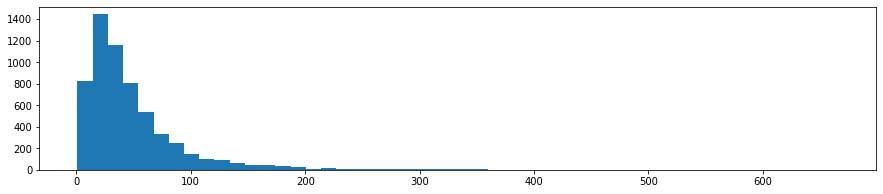

In [0]:
# check the length of reviews
plt.figure(figsize=(15, 3))
word_count = [len(tokenized_texts[i]) for i in range(len(tokenized_texts))]
plt.hist(word_count, bins=50)
# it's safe for now to chose a length of 256 words

FlauBERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the FlauBERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. We use one sentence inputs, this is simply a sequence of 0s. 
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens .
- **labels**: Not suitable for us.

Although we can have variable length input sentences, FlauBERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the FlauBERT tokenizer to convert the tokens to their index numbers in the FlauBERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

In [0]:
# the first 128 words' index in FlauBERT vocabulary
input_ids[10]
len(input_ids[10])
print(input_ids[10])

[ 3789  9089  8236  4916  1150  3554 24254  9089  3179 11317  1277 11943
 15308 19218 25924  1381  1034 38817  5546   837  3690 24624 25590 14532
  3866  3979  3630 24665   280   303  4052 22904 33992  4204  3449  1821
  8142   675  1796  9089  5100  5512 15873 13659 28897  9089  9089 40122
  6357  9089   479  1721  2452  1137  9897     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
train_inputs = input_ids
train_masks = attention_masks

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

input_ids_tensor = torch.tensor(train_inputs)
masks_tensor = torch.tensor(train_masks)

In [0]:
train_inputs.shape

(6000, 128)

## Get encoded layers via FlauBERT

In [0]:
# Load pre-trained model (weights)

# Choose among ['flaubert-small-cased', 'flaubert-base-uncased', 'flaubert-base-cased', 'flaubert-large-cased']
modelname = 'flaubert-base-uncased' 

# Load pretrained model and tokenizer
#by defauly Flaubert return only the last hidden layer: output_hidden_states=False
model, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True,output_hidden_states=False)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=True)
# do_lowercase=False if using cased models, True if using uncased ones

In [0]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


In [0]:
import time
%time
words_in_reviews = []
reviews_embedding=[]
all_batches=[]
for b in tqdm(batch(range(0, 6000), 2)):    #len(input_ids_tensor))
    thirteenlayers=[]
    with torch.no_grad():
        encoded_layers_b = model(input_ids_tensor[b], masks_tensor[b].to(torch.int64)) #[-4:] #We take here the weights the the all layers
        reviews_embedding.append(encoded_layers_b)
        
        #for multi layers
        '''encoded_layers_b = model(input_ids_tensor[b], masks_tensor[b].to(torch.int64))[1][-1] #[-4:] #We take here the weights the the all layers
        for layers in encoded_layers_b:
        thirteenlayers.append(layers)
        all_batches.append(thirteenlayers)'''


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
reviews_embedding[0][0].shape
len(reviews_embedding[1])

1

In [0]:
#when we take only the last layer

#get the matrix of the 6000 reviews *13 layers* 256 words * 768embed
encoded_layers=[]
newtensor=torch.Tensor()
for l in range(1):
    for b in range(len(reviews_embedding)): #5
      if b==0:
        print(b,l)
        newtensor=reviews_embedding[b][l]
      else:
        #tensor_layer[l]=all_batches[b][l]
        newtensor=torch.cat((newtensor,reviews_embedding[b][l]),0)
        if b%500==0:
          print(b,l)
        
    encoded_layers.append(newtensor) 

0 0
500 0
1000 0
1500 0
2000 0
2500 0


In [0]:
# only if multi layers
# get the matrix of the 6000 reviews *13 layers* 256 words * 768embed
encoded_layers = []
newtensor = torch.Tensor()
for l in range(1):
    for b in range(len(all_batches)):  # 5
      if b == 0:
        print(b, l)
        newtensor = all_batches[b][l]
      else:
        # tensor_layer[l]=all_batches[b][l]
        newtensor = torch.cat((newtensor, all_batches[b][l]), 0)
        if b % 500 == 0:
          print(b, l)

    encoded_layers.append(newtensor

In [0]:
len(encoded_layers)
encoded_layers[0].shape

torch.Size([6000, 128, 768])

In [0]:
print("Number of layers:", len(encoded_layers))
layer_i = 0

print("Number of reviews:", len(encoded_layers[layer_i]))
batch_i = 0

print("Number of tokens in each review:",
      len(encoded_layers[layer_i][batch_i]))
token_i = 0

print("Number of hidden units:", len(
    encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 1
Number of reviews: 6000
Number of tokens in each review: 128
Number of hidden units: 768


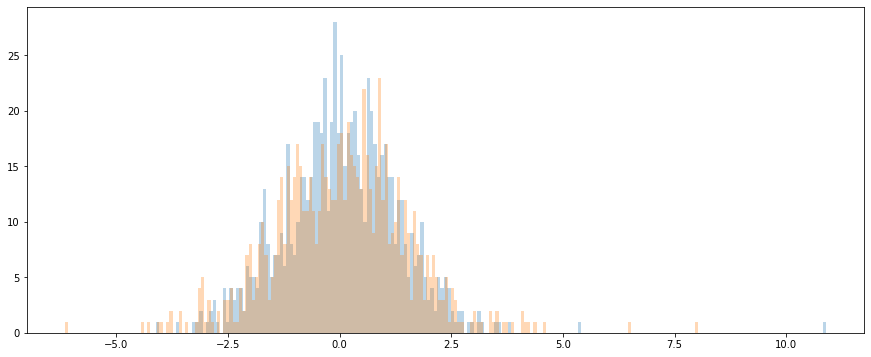

In [0]:
# For the 3 random tokens in our mail, select its feature values from layer 12.
token_i = 4
layer_i = 0
vec = encoded_layers[layer_i][batch_i][token_i]
vec2 = encoded_layers[layer_i][batch_i][token_i+1]
vec3 = encoded_layers[layer_i][batch_i][token_i+5]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15, 6))
#plt.hist(vec, bins=200,alpha=0.3)
plt.hist(vec2, bins=200, alpha=0.3)
plt.hist(vec3, bins=200, alpha=0.3)
plt.show()

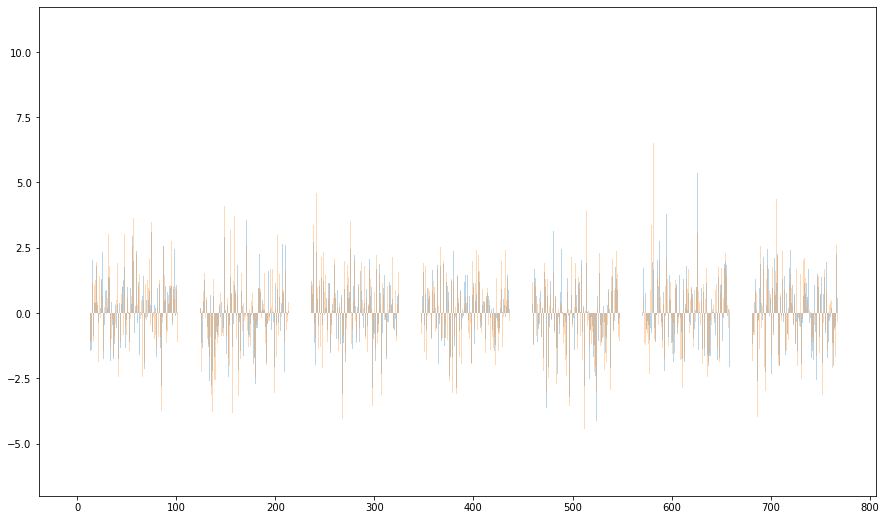

In [0]:
# For the 3 random tokens in our mail, select its feature values from layer 12.
token_i = 4
layer_i = 0
vec = encoded_layers[layer_i][batch_i][token_i]
vec2 = encoded_layers[layer_i][batch_i][token_i+1]
vec3 = encoded_layers[layer_i][batch_i][token_i+5]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15, 9))
# plt.bar(range(768),vec,alpha=0.3)
plt.bar(range(768), vec2, alpha=0.3)
plt.bar(range(768), vec3, alpha=0.3)
plt.show()

In [0]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([6000, 128, 768])


##### Save the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pickle

pickle_out = open("all_batches.pickle", "wb")
pickle.dump(all_batches, pickle_out)
pickle_out.close()

In [0]:
torch.save(encoded_layers,
           '/content/drive/My Drive/CLS6000Flaubert_encoded_layers0413.pt')

## Get embedding with 4 last layers

In [0]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

torch.Size([1, 6000, 128, 768])

In [0]:
# Finally, we can switch around the “layers” and “tokens” dimensions with permute.

# Swap dimensions 0 and 1.
text_embeddings = token_embeddings.permute(1, 2, 0, 3)
text_embeddings.size()

torch.Size([6000, 128, 1, 768])

In [0]:
text_embeddings.size()

torch.Size([6000, 128, 1, 768])

## Text Vectors
To get a single vector for our entire review we have multiple application-dependent strategies, 
but a simple approach is to average all tokens of an review producing a single 768 length vector.

In [0]:
# `text_embeddings` is a [n_emails, 128, 12, 768] tensor.

text_vecs = []

for text in text_embeddings:
  # Stores the token vectors
  token_vecs_sum = []

  # For each token in the text[128, 12, 768]
  for token in text:
    
      # `token` is a [12 x 768] tensor

      # Sum the vectors from the last four layers.
      sum_vec = torch.sum(token[-4:], dim=0)
    
      # Use `sum_vec` to represent `token`.
      token_vecs_sum.append(sum_vec)
  
  text_vecs.append(token_vecs_sum)
  
print ('Shape of word vector is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))
print ('Shape of text vector: %d x %d x ' % (len(text_vecs), len(text_vecs[0])),text_vecs[0][0].size())

Shape of word vector is: 128 x 768
Shape of text vector: 6000 x 128 x  torch.Size([768])


In [0]:
review_embedding = []
for review in text_vecs:
    # print(review)
    word_embedding_sum = np.zeros(768)
    for word in review:
        word_embedding_sum = word_embedding_sum+word.cpu().numpy()
    review_embedding.append(np.array(word_embedding_sum)/128)

In [0]:
len(review_embedding)

6000

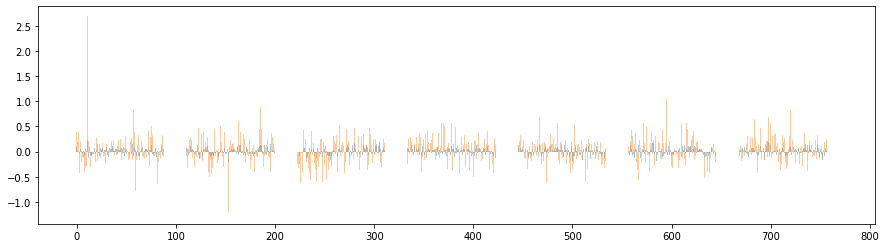

In [0]:
vec = review_embedding[59]
vec2 = review_embedding[4]
vec3 = review_embedding[6]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15, 4))
plt.bar(range(768), vec, alpha=0.4)
plt.bar(range(768), vec2, alpha=0.4)
#plt.bar(range(768),vec3, alpha=0.3)
plt.show()

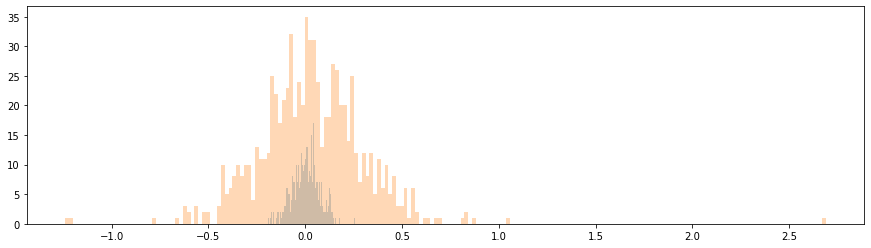

In [0]:
# For the 3 random  mail, visualise the representation features.

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15, 4))
plt.hist(vec, bins=200, alpha=0.3)
plt.hist(vec2, bins=200, alpha=0.3)
#plt.hist(vec3, bins=200,alpha=0.3)
plt.show()

In [0]:
# save the embedding
torch.save(review_embedding, '/content/drive/My Drive/Colab Notebooks/CLS6000_review_embedding0414.pt')

In [9]:
#load teh embedding 
#review_embedding=torch.load( '/content/drive/My Drive/Colab Notebooks/CLS6000_review_embedding0414.pt')
review_embedding=torch.load('/Users/yang/Documents/GitHub/Projet_Fil_Rouge-IBM/CLS project/CLS6000_review_embedding0414.pt')

# Clustering
## K Means

In [102]:
# transform list to array
review_embedding_array = np.array(review_embedding)

In [209]:
from sklearn.cluster import KMeans
N = 3
clf = KMeans(n_clusters=N,
             max_iter=50,
             init='k-means++',
             n_init=4)
labels = clf.fit_predict(review_embedding_array)

## Visualisation with PCA


In [207]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(review_embedding_array)
datapoint = pca.transform(review_embedding_array)

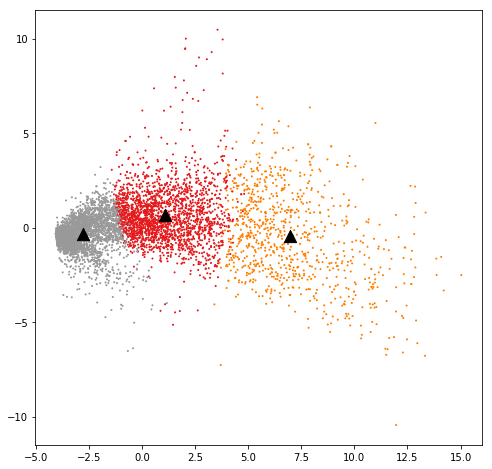

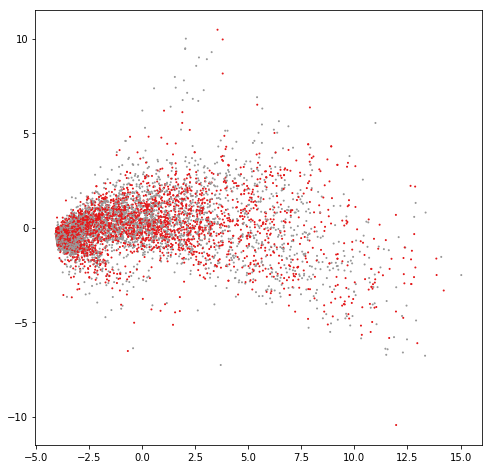

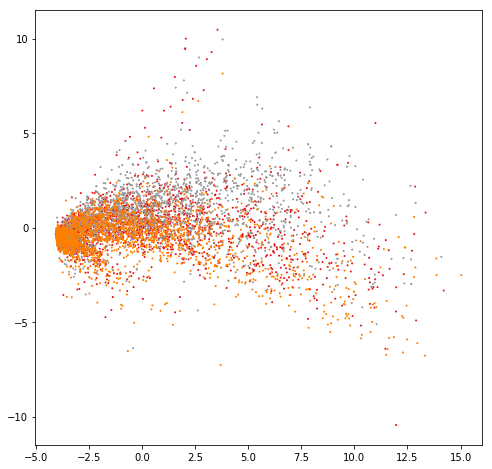

In [228]:
plt.figure(figsize=(8, 8))
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, cmap='Set1', s=1)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1],
            marker='^', s=150, c='#000000')

plt.figure(figsize=(8, 8))
ax.set_title('view with Ground Truth - bi_rating_labels')
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=bi_rating_labels, cmap='Set1', s=1)

plt.figure(figsize=(8, 8))
ax.set_title('view with Ground Truth - bi_rating_labels')
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=categorie_labels, cmap='Set1', s=1)

plt.show()

In [222]:
pca = PCA(n_components=3).fit(review_embedding_array)
datapoint = pca.transform(review_embedding_array)

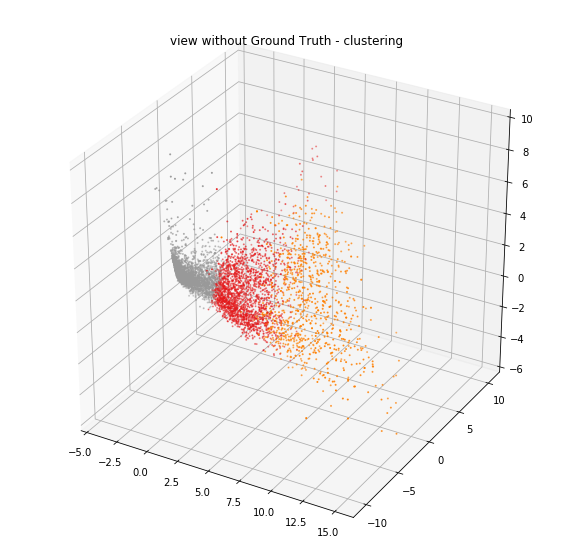

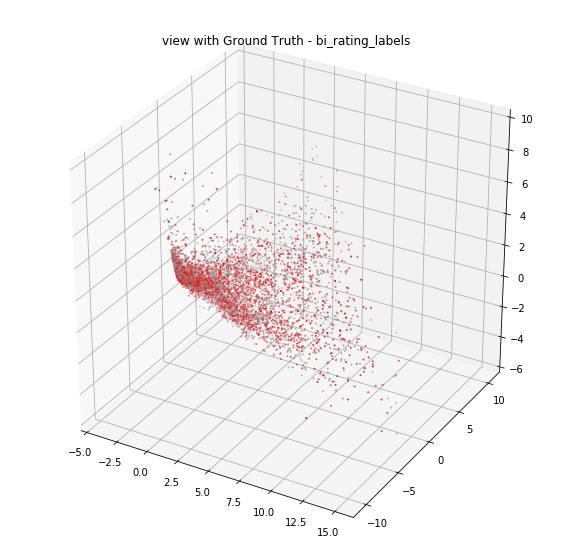

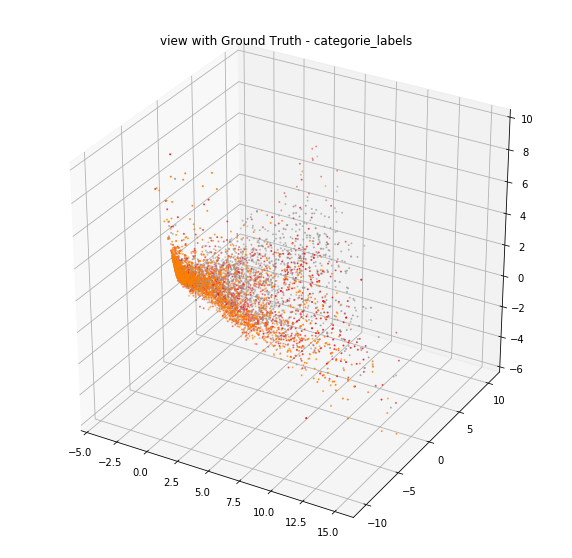

In [232]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=labels, cmap='Set1', s=1)
ax.set_title('view without Ground Truth - clustering')

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=bi_rating_labels, cmap='Set1', s=1)
ax.set_title('view with Ground Truth - bi_rating_labels')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=categorie_labels, cmap='Set1', s=1)
ax.set_title('view with Ground Truth - categorie_labels')
plt.show()

## Visualisation with TSNE

In [234]:
tSNE = TSNE(n_components=2)
datapoint = tSNE.fit_transform(review_embedding_array)

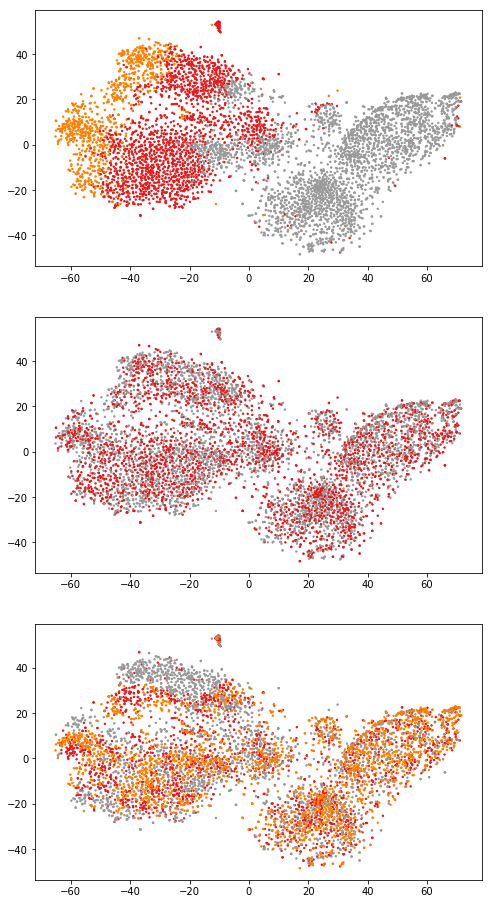

In [235]:
plt.figure(figsize=(8, 16))
plt.subplot(311)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, cmap='Set1', s=2)
plt.subplot(312)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=bi_rating_labels, cmap='Set1', s=2)
plt.subplot(313)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=categorie_labels, cmap='Set1', s=2)
plt.show()

In [0]:
tSNE = TSNE(n_components=3)
datapoint = tSNE.fit_transform(review_embedding_array)

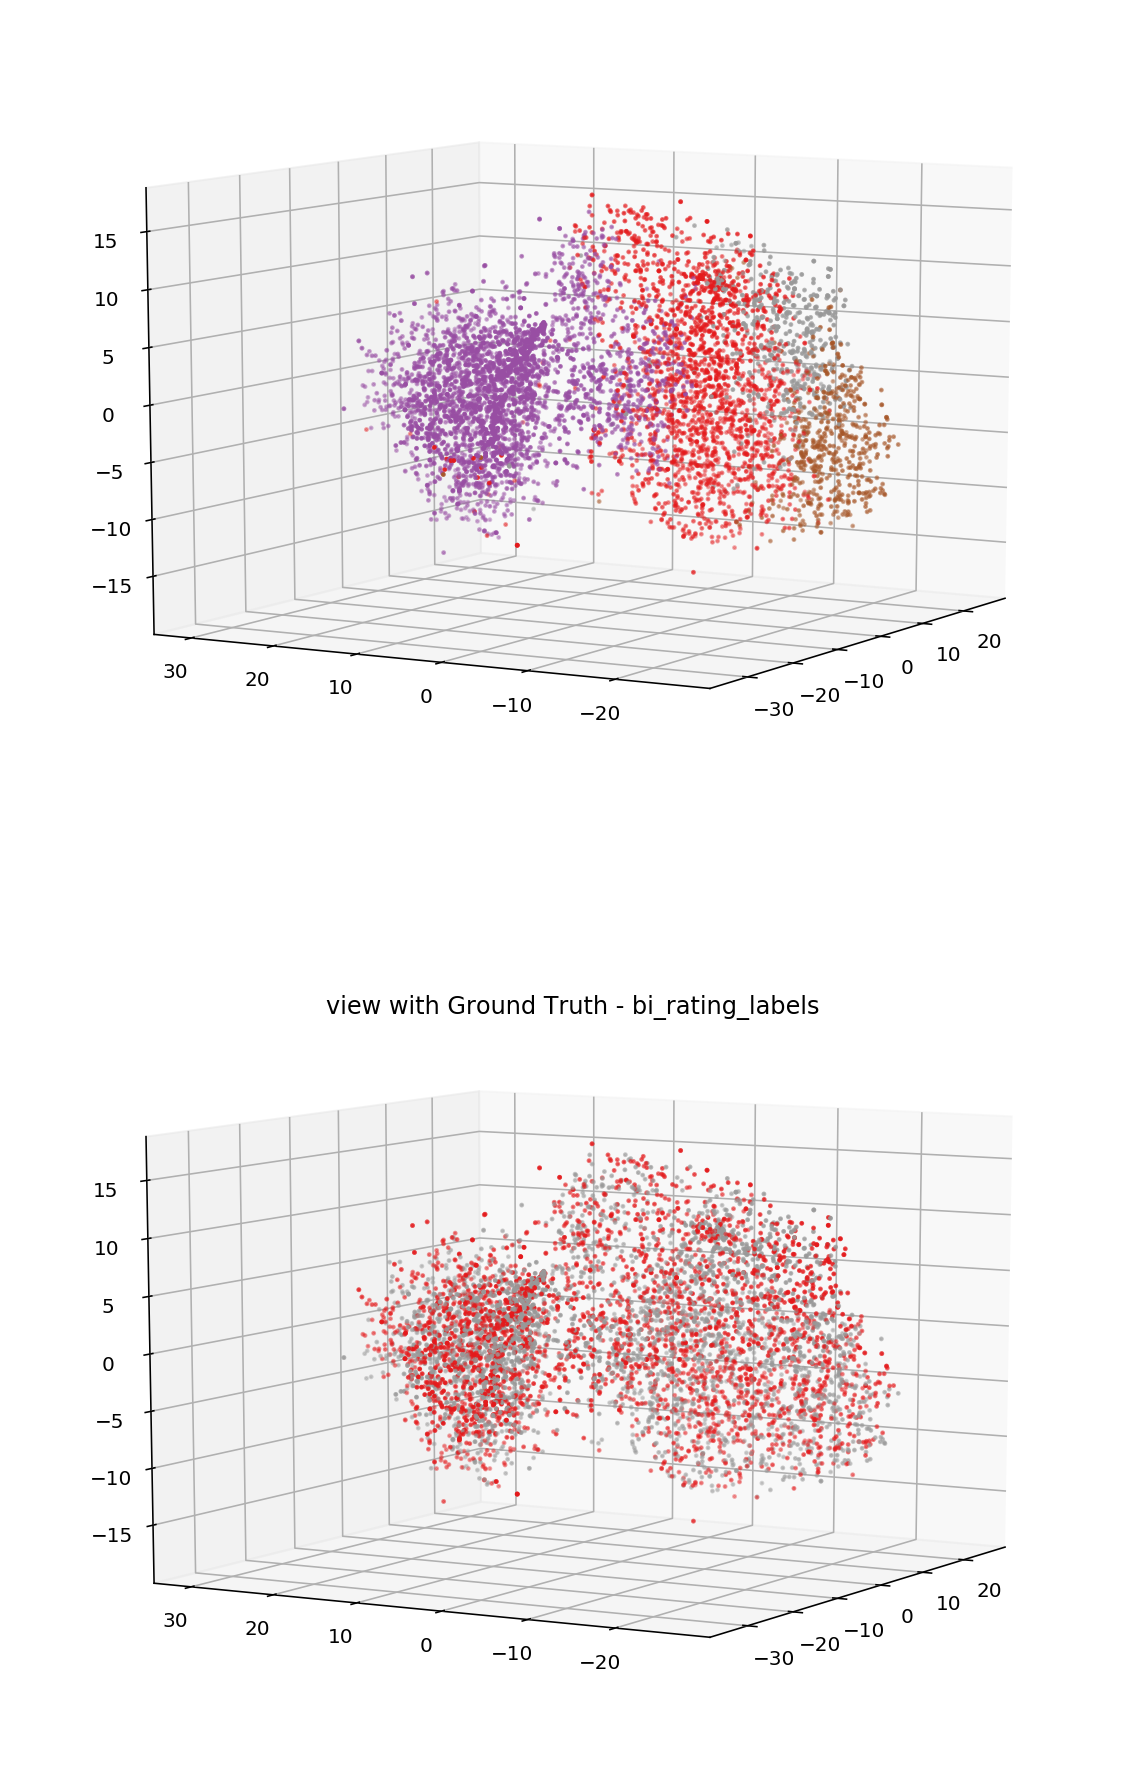

In [192]:
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(211, projection='3d')

ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=labels, cmap='Set1', s=2)
ax.view_init(elev=10., azim=210)
ax = fig.add_subplot(212, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=bi_rating_labels, cmap='Set1', s=2)
ax.view_init(elev=10., azim=210)
ax.set_title('view with Ground Truth - bi_rating_labels')
plt.show()

## AgglomerativeClustering

A big advantage of AgglomerativeClustering is that we can use different metrics, expecially “euclidean”, and “manhattan”. The difference between metrics is usually significant in high dimension. 

affinitystr or callable, default=’euclidean’
Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted. If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.

linkage{“ward”, “complete”, “average”, “single”}, default=”ward”
Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

- ward minimizes the variance of the clusters being merged.

- average uses the average of the distances of each observation of the two sets.

- complete or maximum linkage uses the maximum distances between all observations of the two sets.

- single uses the minimum of the distances between all observations of the two sets.

In [174]:
clf = AgglomerativeClustering(n_clusters=2,affinity='euclidean').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

0.5015


In [169]:
clf = AgglomerativeClustering(n_clusters=2,affinity='euclidean' ,linkage='complete').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

clf = AgglomerativeClustering(n_clusters=2,affinity='euclidean' ,linkage='average').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

clf = AgglomerativeClustering(n_clusters=2,affinity='euclidean' ,linkage='single').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

clf = AgglomerativeClustering(n_clusters=2,affinity='manhattan',linkage='complete').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

clf = AgglomerativeClustering(n_clusters=2,affinity='l2',linkage='average').fit(review_embedding_array)
hc_labels=clf.labels_
print(accuracy_score(bi_rating_labels, hc_labels))

0.5015
0.49983333333333335
0.49983333333333335
0.49983333333333335
0.49983333333333335
0.49983333333333335


In [236]:
tSNE = TSNE(n_components=2)
datapoint = tSNE.fit_transform(review_embedding_array)

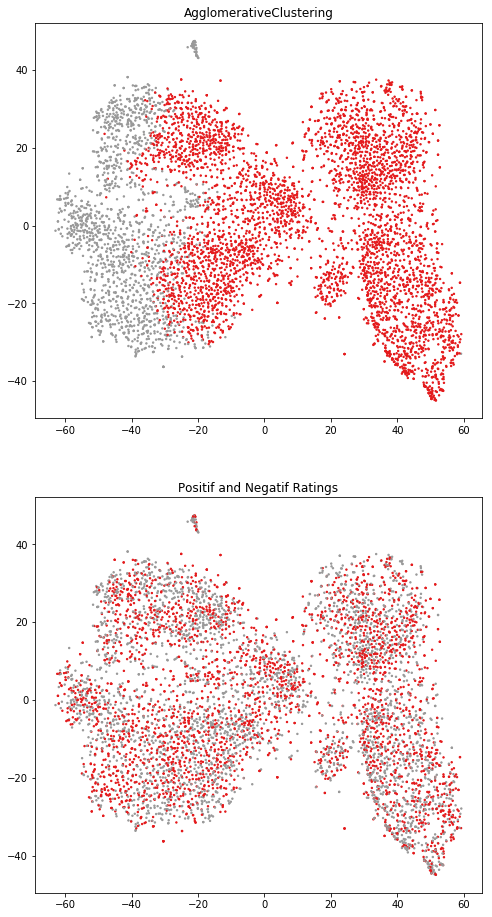

In [237]:
plt.figure(figsize=(8, 16))
plt.subplot(211)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=hc_labels, cmap='Set1', s=2)
plt.title('AgglomerativeClustering')
plt.subplot(212)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=bi_rating_labels, cmap='Set1', s=2)
plt.title('Positif and Negatif Ratings')
plt.show()

In [188]:
tSNE = TSNE(n_components=3)
datapoint = tSNE.fit_transform(review_embedding_array)

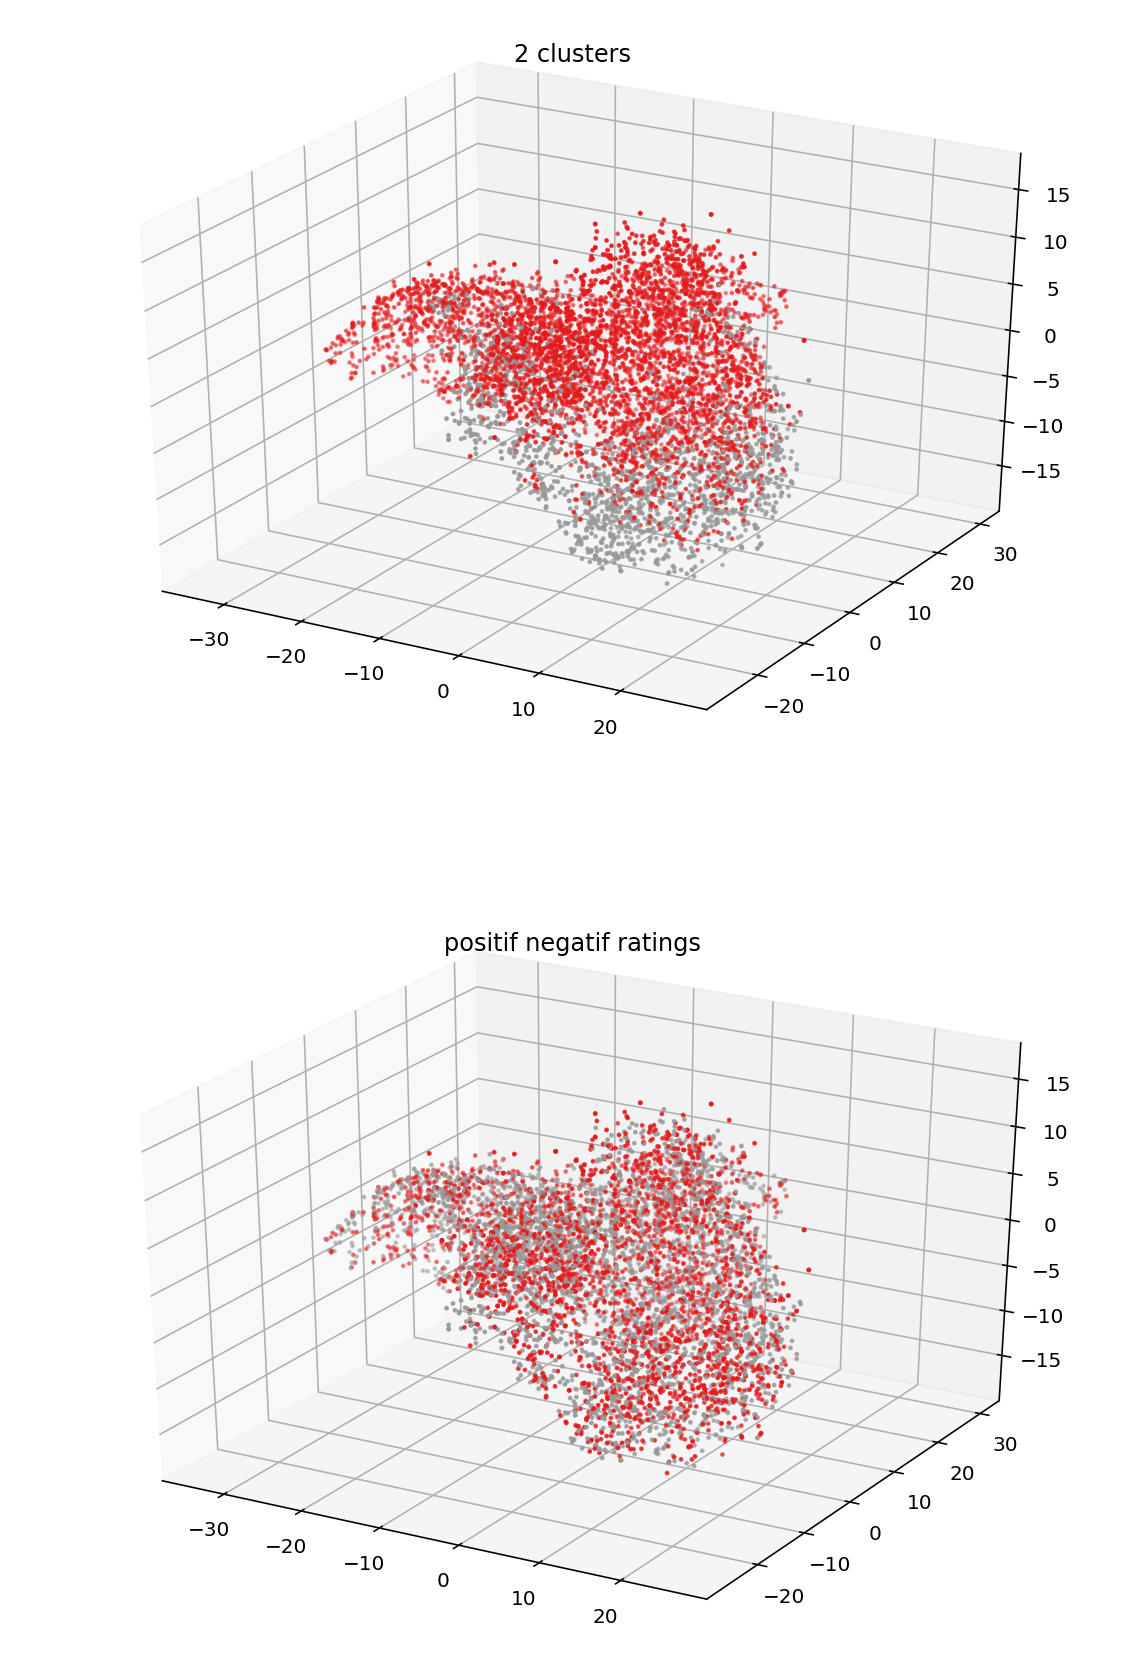

In [191]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=hc_labels, cmap='Set1', s=2)
ax.set_title('2 clusters')
ax = fig.add_subplot(212, projection='3d')
ax.scatter(datapoint[:, 0], datapoint[:, 1],
           datapoint[:, 2], c=bi_rating_labels, cmap='Set1', s=2)
ax.set_title('positif negatif ratings')
plt.show()

## Evaluation of clustering

### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.

- b: The mean distance between a sample and all other points in the next nearest cluster.

- s=(b-a)/max(a,b)

The Silhouette Coefficient s for a single sample is then given as:

 
The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.


Advantages
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [0]:
from sklearn import metrics
#from sklearn.metrics import pairwise_distances

for N in range(2, 7):
    clf = KMeans(n_clusters=N,
                 max_iter=50,
                 init='k-means++',
                 n_init=4)
    labels = clf.fit_predict(review_embedding_array)

    print(N, "clusters, with metrics.silhouette_score: ", metrics.silhouette_score(
        review_embedding_array, labels, metric='euclidean'))

2 clusters, with metrics.silhouette_score:  0.3085818905612367
3 clusters, with metrics.silhouette_score:  0.15657653787955444
4 clusters, with metrics.silhouette_score:  0.15250549659649212
5 clusters, with metrics.silhouette_score:  0.10864054622783972
6 clusters, with metrics.silhouette_score:  0.11641062007643015


### Davies-Bouldin Index
If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.texte en gras

In [0]:
from sklearn.metrics import davies_bouldin_score

for N in range(2,7):
  clf = KMeans(n_clusters=N,
              max_iter=50,
              init='k-means++',
              n_init=4)
  labels = clf.fit_predict(review_embedding_array)

  print(N,"clusters, with davies_bouldin_score: ",davies_bouldin_score(review_embedding_array, labels))

2 clusters, with davies_bouldin_score:  1.7322586521951153
3 clusters, with davies_bouldin_score:  2.2110005474279846
4 clusters, with davies_bouldin_score:  2.4915773031568254
5 clusters, with davies_bouldin_score:  2.623665093833023
6 clusters, with davies_bouldin_score:  2.48579191339431


# Keyword Extraction

https://monkeylearn.com/keyword-extraction/

What is Keyword Extraction?
Keyword extraction (also known as keyword detection or keyword analysis) is a text analysis technique that consists of automatically extracting the most important words and expressions in a text. It helps summarize the content of a text and recognize the main topics which are being discussed.

## WordCloud

In [0]:
#read saved csv files
review_embedding_array = pandas.read_csv('embedding_array.csv' , header=None) 

In [ ]:
def draw_wordcloud(text,label):
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    plt.figure(figsize=(6, 6))
    text = str(text)

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", mask=mask,max_font_size=50).generate(text) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(label)
    plt.show()

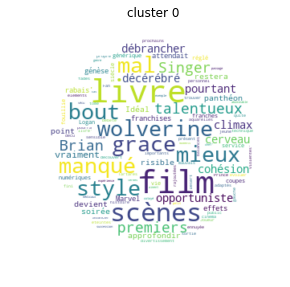

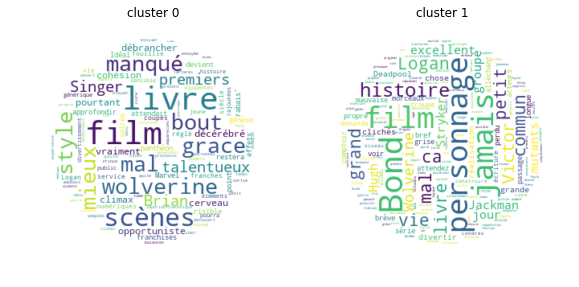

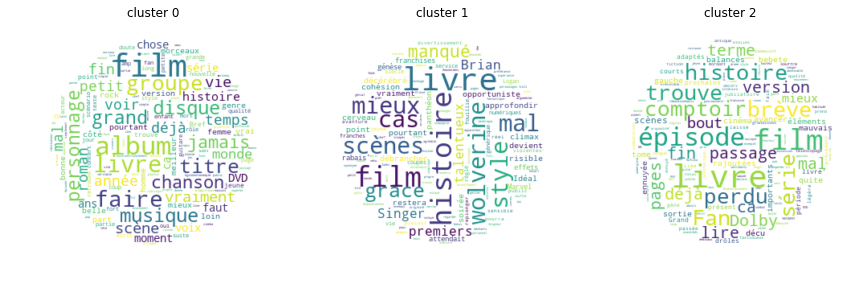

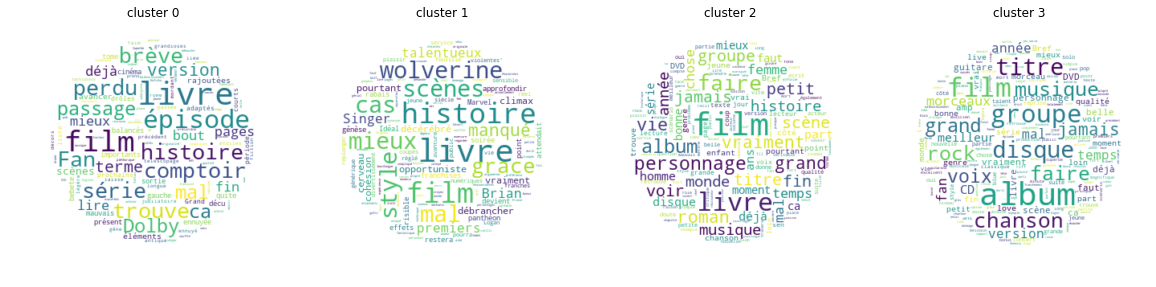

In [164]:
for N in range(4):
    clf = KMeans(n_clusters=N+1,
                 max_iter=50,
                 init='k-means++',
                 n_init=4)
    labels = clf.fit_predict(review_embedding_array)

    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    plt.figure(figsize=(25, 30))
    for label in np.unique(labels):
        plt.subplot(1, 5, label+1)
        text = str(data[0:len(review_embedding)
                        ].review.values[labels == label])

        # Generate a word cloud image
        wordcloud = WordCloud(background_color="white", mask=mask,max_font_size=40).generate(
            text)  

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("cluster %d" % label)
        #plt.show()

## RAKE


Rapid Automatic Keyword Extraction (RAKE) is a well-known keyword extraction method which uses a list of stopwords and phrase delimiters to detect the most relevant words or phrases in a piece of text,as described in this paper.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.657.8134&rep=rep1&type=pdf

RAKE Matrix

After that matrix is built, words are given a score. That **score can be calculated as the degree of a word in the matrix (i.e. the sum of the number of co-occurrences the word has with any other content word in the text), as the word frequency (i.e. the number of times the word appears in the text), or as the degree of the word divided by its frequency.**

RAKE frequency score

Those expressions are also given a score, which is computed as the sum of the individual scores of words. 

RAKE phrases

If two keywords or keyphrases appear together in the same order more than twice, a new keyphrase is created regardless of how many stopwords the keyphrase contains in the original text. The score of that keyphrase is computed just like the one for a single keyphrase.

**A keyword or keyphrase is chosen if its score belongs to the top T scores where T is the number of keywords you want to extract**. According to the original paper, T defaults to one third of the content words in the document.

### Multi-rake
Multilingual Rapid Keyword Extraction (RAKE)

Automatic keyword extraction from text written in any language, and for us, in french.

In [ ]:
pip install multi-rake

In [146]:
from multi_rake import Rake

rake = Rake(
    min_chars=1,
    max_words=4,
    min_freq=1,
    language_code='fr',  # 'en'
    stopwords=None,  # {'and', 'of'}
    max_words_unknown_lang=2,
    generated_stopwords_percentile=100,
    generated_stopwords_max_len=3,
    generated_stopwords_min_freq=2,
)

t = str(data[0:len(data.review)].review)
k=4

keywords = rake.apply(
    str(data[0:len(data.review)].review), text_for_stopwords=None)
print( "====global keywords====:", '\n', keywords[:k])

====global keywords====: 
 [('5978 livre petit chef', 9.0), ('scénario excellent thri', 9.0), ('25 voir films', 4.0), ('5996 roman lit', 4.0)]


====DVD keywords====: 
 [('avaler scénario indigeste mauvais', 16.0), ('vie intellectuel sottise vo', 16.0), ('25 voir films', 4.0), ('1984 sûr apprend', 4.0), ('barbra f', 4.0), ('présence scène', 4.0), ('1983 tenter', 1.0)] 



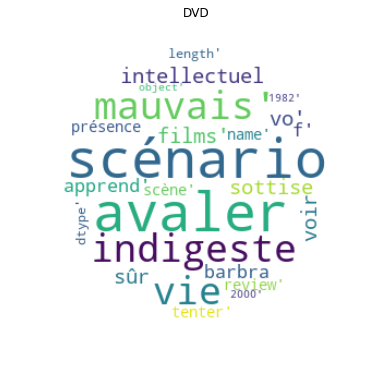

====Musiquel keywords====: 
 [('avouer album mauvai', 9.0), ('2011 chanteur tube arrivant', 9.0), ('2006 fan albums précédents', 8.5), ('albums douter', 4.5), ('fu', 1.0), ('2023 essayer', 1.0), ('2029 dépenser', 1.0)] 



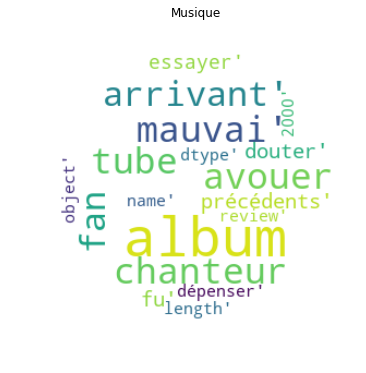

====Livres keywords====: 
 [('5978 livre petit chef', 9.0), ('scénario excellent thri', 9.0), ('5996 roman lit', 4.0), ('name', 1.0), ('review', 1.0), ('length', 1.0), ('dtype', 1.0)] 



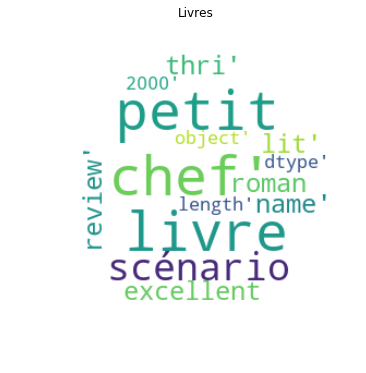

In [162]:
k=7
keywords = rake.apply(
    str(reviews[data.category == 'DVD']), text_for_stopwords=None)
print("====DVD keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'DVD')

keywords = rake.apply(
    str(reviews[data.category == 'Musique']), text_for_stopwords=None)
print("====Musiquel keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'Musique')

keywords = rake.apply(
    str(reviews[data.category == 'Livres']), text_for_stopwords=None)
print("====Livres keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'Livres')

====rating=5 keywords====: 
 [('voir voix incomparable cl', 15.0), ('54 festival compte dvd', 9.0), ('stupeur noël monsie', 9.0), ('5978 livre petit chef', 9.0), ('scénario excellent thri', 9.0), ('25 voir films', 5.0), ('53 film pleinement', 4.0), ('couper', 1.0), ('posséder', 1.0), ('64 oui', 1.0)] 



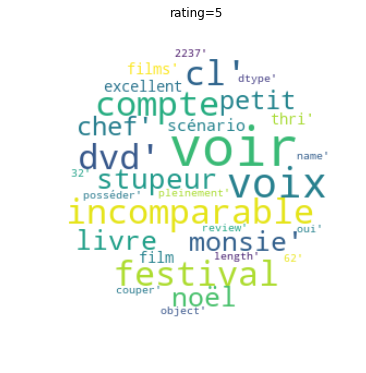

====rating=4 keywords====: 
 [('faible co', 4.0), ('5996 roman lit', 4.0), ('li', 1.0), ('bébé', 1.0), ('name', 1.0), ('review', 1.0), ('length', 1.0), ('dtype', 1.0), ('object', 1.0), ('763', 0)] 



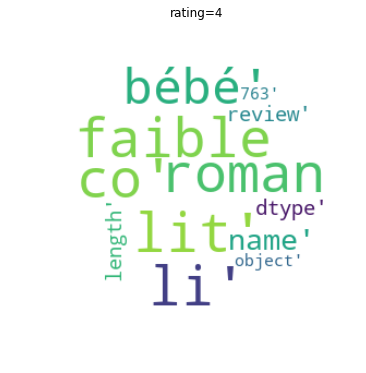

====rating=2 keywords====: 
 [('5913 intéressant neutre essaie', 9.0), ('croire fanatiq', 4.0), ('name', 1.0), ('review', 1.0), ('length', 1.0), ('dtype', 1.0), ('object', 1.0), ('1404', 0)] 



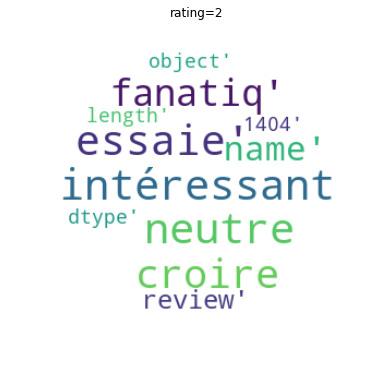

====rating=1 keywords====: 
 [('petits japonais commencer sabr', 16.0), ('50 rater coffret série', 9.0), ('demander géré coffret', 9.0), ('122 film héros', 4.0), ('ratage', 1.0), ('5931 critiques', 1.0), ('name', 1.0), ('review', 1.0), ('length', 1.0), ('dtype', 1.0)] 



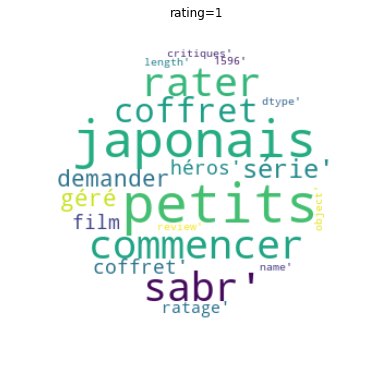

In [161]:
k=10
keywords = rake.apply(
    str(reviews[data.rating == 5]), text_for_stopwords=None)
print("====rating=5 keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'rating=5')

keywords = rake.apply(
    str(reviews[data.rating == 4]), text_for_stopwords=None)
print("====rating=4 keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'rating=4')

keywords = rake.apply(
    str(reviews[data.rating == 2]), text_for_stopwords=None)
print("====rating=2 keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'rating=2')

keywords = rake.apply(
    str(reviews[data.rating == 1]), text_for_stopwords=None)
print("====rating=1 keywords====:", '\n', keywords[:k], '\n')
draw_wordcloud(keywords,'rating=1')

# Supervised study

## creat classes

In [86]:
from sklearn.preprocessing import LabelEncoder
gle = LabelEncoder()
categorie_labels = gle.fit_transform(data['category'])
categorie_maping = {index: label for index, label in enumerate(gle.classes_)}

rating_labels = gle.fit_transform(data['rating'])
rating_maping = {index: label for index, label in enumerate(gle.classes_)}

bi_rating_labels = []
for rating in data['rating']:
    if rating <= 3:
        bi_rating_labels.append(0)
    else:
        bi_rating_labels.append(1)

print(categorie_maping)
print(rating_maping)

{0: 'DVD', 1: 'Livres', 2: 'Musique'}
{0: 1.0, 1: 2.0, 2: 4.0, 3: 5.0}


In [109]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

N = 2
clf = KMeans(n_clusters=N,
             max_iter=50,
             init='k-means++',
             n_init=4)
labels = clf.fit_predict(review_embedding_array)

accuracy_score(bi_rating_labels, labels)

0.5028333333333334

In [110]:
N = 3
clf = KMeans(n_clusters=N,
             max_iter=50,
             init='k-means++',
             n_init=4)
labels = clf.fit_predict(review_embedding_array)
accuracy_score(categorie_labels, labels)

0.29433333333333334

In [112]:
pip install lightgbm

     |████████████████████████████████| 679 kB 8.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

y_train = bi_rating_labels[0:5000]
y_test = bi_rating_labels[5000:]
X_train = review_embedding_array[0:5000]
X_test = review_embedding_array[5000:]

# train
gbm=LogisticRegression(solver='lbfgs')
'''gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)'''
gbm.fit(X_train, y_train,
       )


# predict
y_pred = gbm.predict(X_test)

accuracy_score(bi_rating_labels[5000:], y_pred)

/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.653

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

y_train = bi_rating_labels[0:50]
y_test = bi_rating_labels[50:]
X_train = review_embedding_array[0:50]
X_test = review_embedding_array[50:]

# train
gbm=LogisticRegression(solver='lbfgs')
'''gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)'''
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)


# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

# UMAP

## Visualisation with ground truth
UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

The data is uniformly distributed on Riemannian manifold;
The Riemannian metric is locally constant (or can be approximated as such);
The manifold is locally connected.
From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

### Document embedding using UMAP

In [202]:
!pip install umap
!pip install umap-learn[plot]
!pip install datashader
!pip install colorcet
!pip install holoviews
!pip install bokeh

Processing /Users/yang/Library/Caches/pip/wheels/3b/73/50/6fe0ae0386b5803013b304a139e3d48bbea84192f6ae82f615/umap_learn-0.4.1-py3-none-any.whl
  Using cached tbb-2019.0-py2.py3-none-macosx_10_12_intel.macosx_10_12_x86_64.whl (565 kB)
  Using cached numba-0.48.0-cp37-cp37m-macosx_10_9_x86_64.whl (2.0 MB)
  Using cached llvmlite-0.31.0-cp37-cp37m-macosx_10_9_x86_64.whl (15.9 MB)


  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.28.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Processing /Users/yang/Library/Caches/pip/wheels/3b/73/50/6fe0ae0386b5803013b304a139e3d48bbea84192f6ae82f615/umap_learn-0.4.1-py3-none-any.whl
  Using cached numba-0.48.0-cp37-cp37m-macosx_10_9_x86_64.whl (2.0 MB)
  Using cached llvmlite-0.31.0-cp37-cp37m-macosx_10_9_x86_64.whl (15.9 MB)


  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.28.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [203]:
from bokeh.resources import INLINE
from bokeh.plotting import show, save, output_notebook, output_file
import umap
import umap.plot
import matplotlib.pyplot as plt
#%matplotlib notebook
output_notebook(resources=INLINE)

ModuleNotFoundError: No module named 'umap.plot'

Now we are going to do dimension reduction using UMAP to reduce the matrix from 34880 dimensions to 2 dimensions (since n_components=2). We need a distance metric and will use Ecleudien distance.

In [204]:
embedding = umap.UMAP(n_components=2).fit(
    review_embedding)  # , metric='hellinger'

# For interactive plotting use
# f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(f)
f = umap.plot.points(embedding, labels=data['category'])

AttributeError: module 'umap' has no attribute 'UMAP'

## Embedding to non-Euclidean spaces

By default UMAP embeds data into Euclidean space. For 2D visualization that means that data is embedded into a 2D plane suitable for a scatterplot. In practice, however, there aren’t really any major constraints that prevent the algorithm from working with other more interesting embedding spaces. In this tutorial we’ll look at how to get UMAP to embed into other spaces, how to embed into your own custom space, and why this sort of approach might be useful.

### Spherical embeddings

In [205]:
sphere_mapper = umap.UMAP(output_metric='haversine',
                          random_state=42).fit(review_embedding)
x = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(x, y, z, c=bi_rating_labels,  s=1)
ax2 = fig.add_subplot(212, projection='3d')
ax2.scatter(x, y, z, c=categorie_labels,  s=1)

AttributeError: module 'umap' has no attribute 'UMAP'

Text(0.5, 1.0, 'categorie_rating_labels')

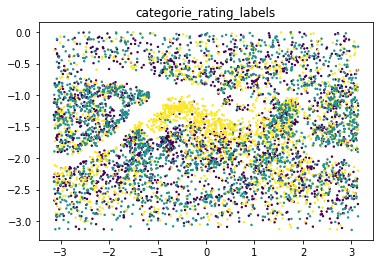

In [0]:
x = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])
x = np.arctan2(x, y)
y = -np.arccos(z)
plt.scatter(x, y, c=categorie_labels,  s=2)
plt.title('categorie_rating_labels')

Text(0.5, 1.0, 'bi_rating_labels')

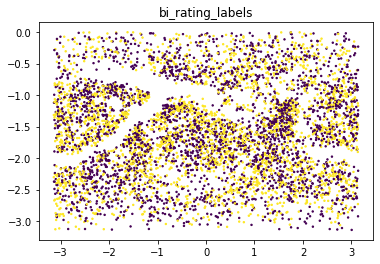

In [0]:
x = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * \
    np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])

x = np.arctan2(x, y)
y = -np.arccos(z)
plt.scatter(x, y, c=bi_rating_labels,  s=2)
plt.title('bi_rating_labels')

### Embedding in Hyperbolic space

The most popular model for this for visualization is Poincare’s disk model. An example of a regular tiling of hyperbolic space in Poincare’s disk model is shown below.

<img src=https://umap-learn.readthedocs.io/en/latest/_images/Hyperbolic_tiling.png width="500">





In [206]:
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid',
                              random_state=42).fit(review_embedding)

plt.scatter(hyperbolic_mapper.embedding_.T[0],
            hyperbolic_mapper.embedding_.T[1],
            c=categorie_labels,  s=2)

AttributeError: module 'umap' has no attribute 'UMAP'

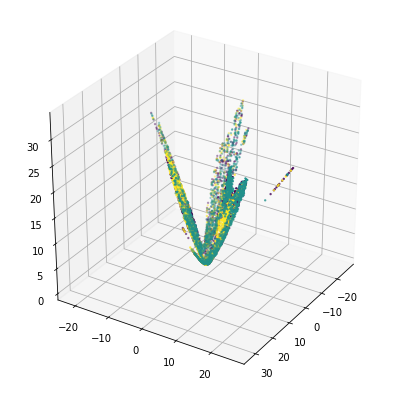

In [0]:
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=categorie_labels, s=2)
ax.view_init(30, 32)

Now we can visualize the data in a Poincare disk model embedding. For this we generate a scatterplot of the data, and then draw in the bounding circle of the line at infinity.

No handles with labels found to put in legend.


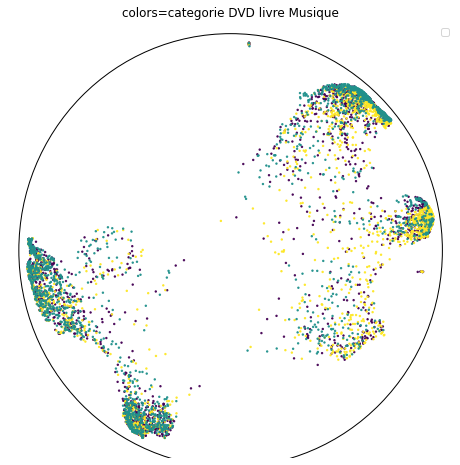

In [0]:
disk_x = x / (1 + z)
disk_y = y / (1 + z)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, c=categorie_labels, alpha=0.9, s=2)
boundary = plt.Circle((0, 0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.set_title('colors=categorie DVD livre Musique')
ax.legend()
ax.axis('off')

No handles with labels found to put in legend.


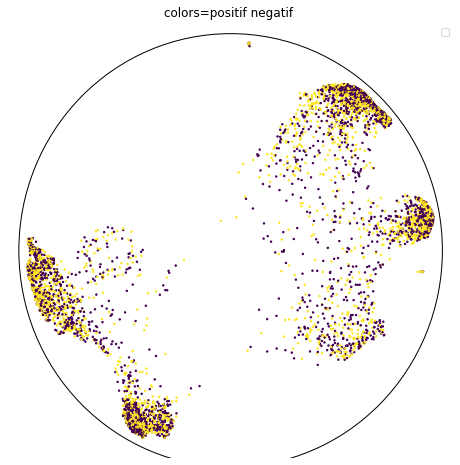

In [0]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, c=bi_rating_labels, s=2)
boundary = plt.Circle((0, 0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.set_title('colors=positif negatif ')
ax.legend()
ax.axis('off')